# Imperfect conductor - Discussion

In [1]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/imperfect_conductor')

# Needed for plotting
import pickle
root = os.path.abspath(os.path.join('__file__' ,'../../..'))

%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('inferno')

import fenics as fen
from imperfect_conductor import ImperfectConductor

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Imperfect conductor

In [3]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
imp = fen.Expression('1.0', degree=2)
RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N, imp=imp)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/fenics/shared/src/time_harmonic_maxwell_problem.py:358: ComplexWarning: Casting complex values to real discards the imaginary part
  u_vec_inserted[inner_indices] = u_vec
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


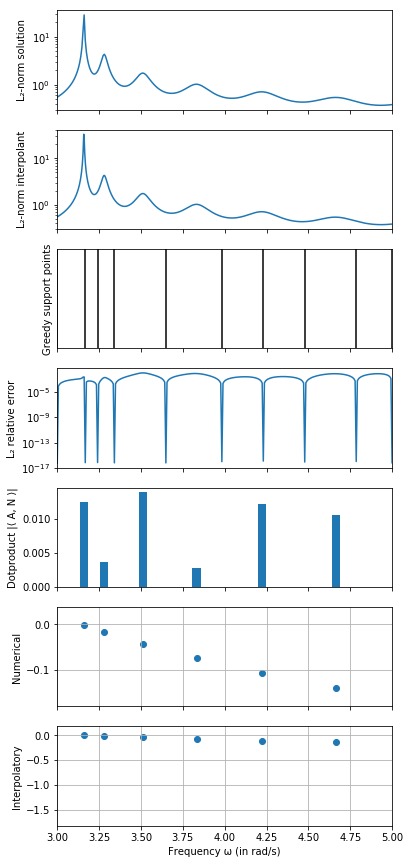

In [4]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.complex_scatter(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

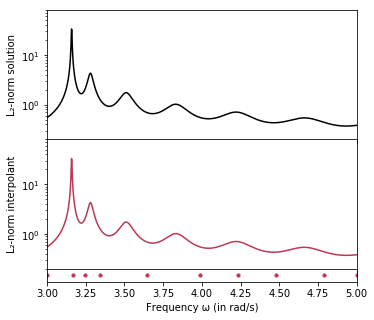

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(5.55, 5), sharex=True, gridspec_kw={'height_ratios': [10, 10, 1]})

a = 3
b = 5
omegas = np.linspace(a, b, 1000)
RC.solve(omegas, solver='scipy')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
FE_norms = helpers.plot_solution_norms(ax[0], solution, VS, color=cm(0.0))

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
RI_norms = helpers.plot_surrogate_norms(ax[1], MRI, a, b, color=cm(0.5))

nodes = MRI.u_ring.get_nodes()
ax[-1].scatter(nodes, np.zeros_like(nodes), s=10, color=cm(0.5))
#helpers.plot_lines(ax[1], MRI.u_ring.get_nodes())

ax[-1].set_yticks([])
ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
ax[0].set_ylim(2e-1, 8e+1)
ax[1].set_ylim(2e-1, 8e+1)
plt.subplots_adjust(wspace=0, hspace=0)

In [17]:
with open(root + '/report/plots/imperfect_conductor_norms.pkl', 'wb') as f:
    pickle.dump([FE_norms, RI_norms, omegas, nodes], f) 

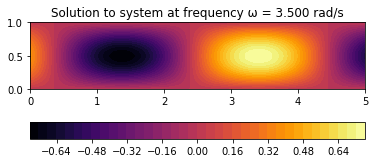

In [30]:
eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

omega = 3.5
RC.solve(omega)
RC.plot_solution(cmap=cm)

In [14]:
solution = RC.get_solution()
coords = RC.V.tabulate_dof_coordinates().reshape((-1, 2))
with open(root + '/report/plots/imperfect_conductor_solution.pkl', 'wb') as f:
    pickle.dump([solution, coords, omega], f)

### Various impedances

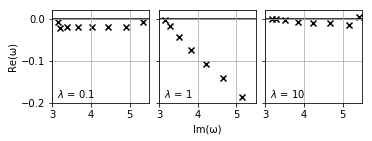

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(5.55, 1.7), sharex=True, sharey=True)

eigfreqs_list = []
imps = [0.1, 1, 10]
for i, imp in enumerate(imps):
    RC.imp = fen.Expression(str(imp), degree=2)
    RC.setup()

    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

    eigfreqs = MRI.get_interpolatory_eigenfrequencies()
    eigfreqs_list.append(eigfreqs)
    helpers.complex_scatter(ax[i], eigfreqs, color='k', marker='x', label='\u03BB = {}'.format(imp))
    ax[i].text(0.05, 0.05, r'$\lambda$ = {}'.format(imp), transform=ax[i].transAxes)
    ax[i].set_xlim(3, 5.5)
    ax[i].set_ylim(-0.2, 0.02)
    ax[i].axhline(0, color='k', linewidth=1.5, zorder=-1)

ax[0].set_ylabel('Re(\u03C9)')
ax[1].set_xlabel('Im(\u03C9)')

plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [85]:
with open(root + '/report/plots/imperfect_conductor_eigfreqs.pkl', 'wb') as f:
    pickle.dump([eigfreqs_list, imps], f)

### Higher impedance

In [ ]:
RC.imp = fen.Expression('10.0', degree=2)
RC.setup()

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/fenics/shared/src/time_harmonic_maxwell_problem.py:358: ComplexWarning: Casting complex values to real discards the imaginary part
  u_vec_inserted[inner_indices] = u_vec
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


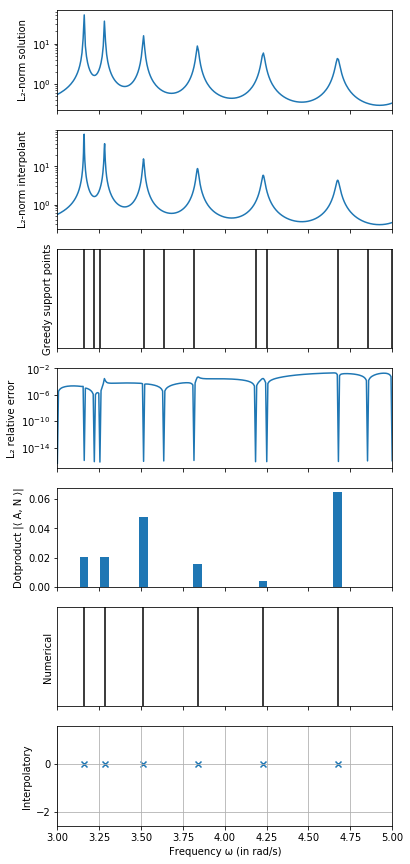

In [42]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

### Lower impedance

In [43]:
RC.imp = fen.Expression('0.1', degree=2)
RC.setup()

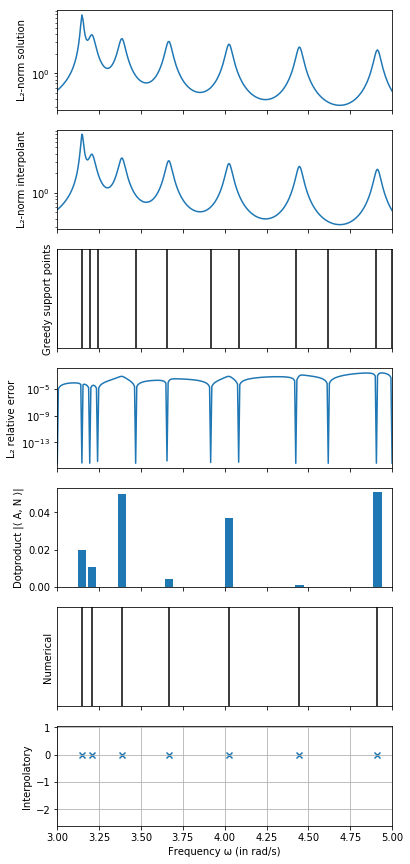

In [44]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

## Compare eigensolver to rational interpolation

In [6]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 300)

imp = fen.Expression('0.1', degree=2)
for N in np.logspace(3, 5, 3, dtype=int):
    RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N, imp=imp)
    RC.setup()
    print(50*'#' + '\nRectangular cavity with {} DOFs\n'.format(RC.V.dim()) + 50*'-')
    VS = VectorSpaceL2(RC)
    eigfreqs_numerical = np.array(RC.get_numerical_eigenfrequencies(a, b, k=7))
    print('eigsh')
    %timeit RC.get_numerical_eigenfrequencies(a, b)
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') 
    eigfreqs_rational_unfiltered = MRI.get_interpolatory_eigenfrequencies()
    eigfreqs_rational = np.sort([e for e in eigfreqs_rational_unfiltered if a <= e and e <= b])
    print('MRI')
    %timeit MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') ; MRI.get_interpolatory_eigenfrequencies()
    print('Mean absolute error {}'.format(np.mean(np.abs(eigfreqs_numerical - eigfreqs_rational))))

##################################################
Rectangular cavity with 713 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
65.1 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MRI
78.5 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.7051129003383544
##################################################
Rectangular cavity with 7412 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
906 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MRI
496 ms ± 53.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean absolute error 0.6897124618158822
##################################################
Rectangular cavity with 74722 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
20.4 s ± 289 ms per loop (mean ±